# **KAU Deep Learning (Spring 2025)**

**NOTE**
Some descriptions & codes from the below resources:
1. https://keras.io/api/applications/
2. CS231n: Convolutional Neural Networks for Visual Recognition at Stanford Univ (https://cs231n.github.io/)
---

## Convolutional Layer Summary

#### Summary.
To summarize, the Conv Layer:

* Accepts a volume of size W1×H1×D1
* Requires four hyperparameters:
 * Number of filters K,
 * their spatial extent F,
 * the stride S,
 * the amount of zero padding P.
* Produces a volume of size W2×H2×D2 where:
 * W2=(W1−F+2P)/S+1
 * H2=(H1−F+2P)/S+1 (i.e. width and height are computed equally by symmetry)
 * D2=K

* With parameter sharing, it introduces F⋅F⋅D1 weights per filter, for a total of (F⋅F⋅D1)⋅K weights and K biases.

* In the output volume, the d-th depth slice (of size W2×H2) is the result of performing a valid convolution of the d-th filter over the input volume with a stride of S, and then offset by d-th bias.

**Convolution Demo**.
Below is a running demo of a CONV layer. Since 3D volumes are hard to visualize, all the volumes (the input volume (in blue), the weight volumes (in red), the output volume (in green)) are visualized with each depth slice stacked in rows.

The input volume is of size **W1=5,H1=5,D1=3**, and the CONV layer parameters are **K=2,F=3,S=2,P=1**. That is, we have two filters of size 3×3, and they are applied with a stride of 2. Therefore, the output volume size has spatial size (5 - 3 + 2)/2 + 1 = 3.

 Moreover, notice that a padding of **P=1** is applied to the input volume, making the outer border of the input volume zero. The visualization below iterates over the output activations (green), and shows that each element is computed by elementwise multiplying the highlighted input (blue) with the filter (red), summing it up, and then offsetting the result by the bias.

In [ ]:
from IPython.display import HTML

HTML('<iframe width="1024" height="768" src="https://cs231n.github.io/assets/conv-demo/index.html"" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/usr/local/lib/python3.11/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Pooling Layer Summary

It is common to periodically insert a Pooling layer in-between successive Conv layers in a ConvNet architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations. Every MAX operation would in this case be taking a max over 4 numbers (little 2x2 region in some depth slice). The depth dimension remains unchanged. More generally, the pooling layer:

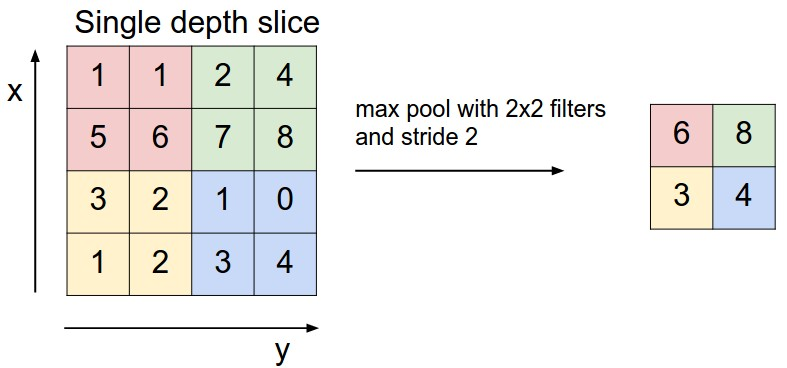

## 0. Loading the cats vs dogs dataset


### **Cats vs Dogs**
The "Cats vs Dogs" is a open dataset for binary classification of cat and dog images. It consists of a total of 10,000 images, with 8,000 images in the training dataset (4,000 cats and 4,000 dogs) and the remaining 2,000 images in the test dataset (1,000 cats and 1,000 dogs). The dataset is composed of image files, primarily in JPEG format. The source of this dataset is Kaggle (https://www.kaggle.com/c/dogs-vs-cats), and it is a publicly available dataset provided by the Kaggle community.

#### Mount Google Drive & Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
local_zip = '/content/drive/MyDrive/Colab Notebooks/2025_1 딥러닝/CatsVsDogs.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/dataset')
zip_ref.close()

In [ ]:
import torch
import pandas as pd
import os
from torchvision import transforms
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip

class CatsDogsDataset(torch.utils.data.Dataset): ## make custom dataset
  def __init__(self, annotation_path ,root_dir = '/dataset'): # root_dir : The parent directory path of the train and test directories.
        'Initialization'

        self.data_annotation = pd.read_csv(os.path.join(annotation_path))
        self.data_path = self.data_annotation['filepath']
        self.labels = self.data_annotation['label']
        self.root_dir = root_dir

        #data preprocessing using torchvision,
        self.transforms = Compose([  # Multiple operations can be combined into a single transformation using 'Compose' in torchvision
            RandomHorizontalFlip(),  # data augmentation : horizontal flip
            Resize((150, 150)), # Due to varying sizes of input images, the images are resized to 224x224
            ToTensor()
        ])

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_path)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        file_path = os.path.join(self.root_dir,self.data_path[index])
        input_image = Image.open(file_path)
        X = self.transforms(input_image) ## data preprocessing
        # Load data and get label
        y = torch.tensor(self.labels[index]).float()

        return X, y

Check dataset

total training images: 8000
total test images: 2000
Torch size: torch.Size([3, 150, 150])


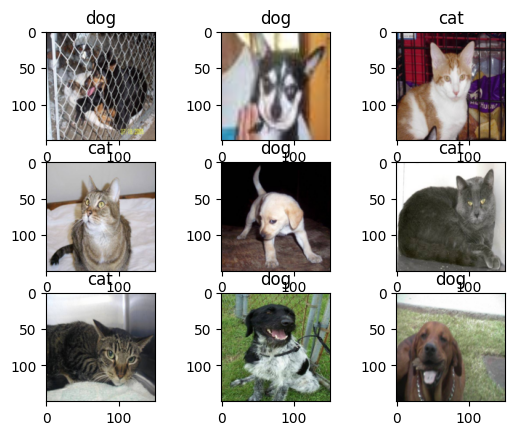

In [ ]:
import matplotlib.pyplot as plt
import random

## make by using custom dataset class
trainset = CatsDogsDataset(annotation_path = '/dataset/train_annotation.csv')
testset = CatsDogsDataset(annotation_path = '/dataset/test_annotation.csv')
print('total training images:', len(trainset))
print('total test images:', len(testset))
print('Torch size:', trainset[0][0].shape)


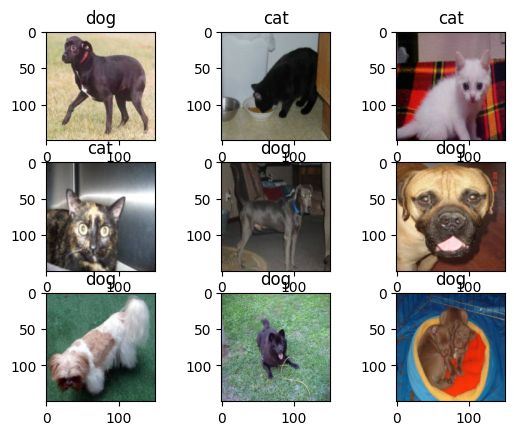

In [ ]:
## visualize
class_names=['cat','dog']
for i in range(9):
  random_index = random.randint(0,8000)
  image, label = trainset[random_index]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.permute(1,2,0).numpy())
  plt.title(class_names[int(label)])
  #plt.axis("off")

Training and Test Function Similar to Last Time

In [ ]:
def train(model, optimizer, train_loader, epoch):
  train_loss = []
  train_accuracy = []
  model.train()
  for i, (X,y) in enumerate(train_loader):
      X,y = X.to(device), y.to(device).view(-1,1)
      optimizer.zero_grad()
      predict = model(X)
      loss = criterion(predict, y)
      loss.backward()
      optimizer.step()

      accuracy = torch.count_nonzero((predict>=0.5) == y)/X.shape[0]
      train_accuracy.append(accuracy)
      train_loss.append(loss)

  avg_loss = sum(train_loss) /len(train_loss)
  avg_accuracy = sum(train_accuracy) / len(train_accuracy)

  return avg_loss.cpu().detach(), avg_accuracy.cpu().detach()

def test(model, optimizer, test_loader, epoch):
  test_loss = []
  test_accuracy = []
  model.eval()
  for i, (X,y) in enumerate(test_loader):
      with torch.no_grad(): ## Since backward computation is not necessary during test time, turning off grad reduces memory and computational overhead.
        X,y = X.to(device), y.to(device).view(-1,1)
        predict = model(X)
        loss = criterion(predict, y)
        accuracy = torch.count_nonzero((predict>=0.5) == y)
        test_accuracy.append(accuracy)
        test_loss.append(loss)

  avg_loss = sum(test_loss) /len(test_loss)
  avg_accuracy = sum(test_accuracy) / len(test_accuracy)
  return avg_loss.cpu().detach(), avg_accuracy.cpu().detach()


## 1. Baseline - LeNet

LeNet is one of the pioneering Convolutional Neural Network (CNN) models introduced in 1998 for handwritten digit recognition. It consists of convolutional layers for feature extraction, pooling layers for downsampling, and fully connected layers for classification. LeNet laid the foundation for modern CNNs and played a significant role in the development of deep learning.

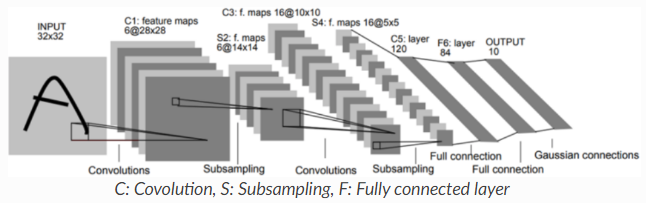

In [ ]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels, 6 output channels, 5x5 kernel--이렇게 정의할 시 기본적으로 bias=True이라 포함됨
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling

        # Write your code
        self.conv2 = nn.Conv2d(6, 6, 5)  # 6 input channels, 6 output channels, 5x5 kernel
        self.fc1=nn.Linear(6*34*34,120)
        self.fc2 = nn.Linear(120, 84)  # fully connected layer, input features: 120, output features: 84
        self.fc3 = nn.Linear(84, 1)  # fully connected layer, input features: 84, output features: 10
        self.sigmoid = nn.Sigmoid() #최종출력 값을 0~1사이의 값으로 변경

    def forward(self, x):
        # Write your code
        #print(f"Input shape: {x.shape}")
        x = self.pool(torch.relu(self.conv1(x)))  # first conv layer + relu + pooling
        #print(f"After conv1 and pool: {x.shape}")
        x = self.pool(torch.relu(self.conv2(x)))  # second conv layer + relu + pooling
        #print(f"After conv2 and pool: {x.shape}")

        # Adjust the size of the tensor to match the expected size by fc1
        x = x.view(x.size(0), -1)  # flattening the tensor
        #print(f"After flattening: {x.shape}")
        x = torch.relu(self.fc1(x))  # first fully connected layer + relu
        #print(f"After fc1: {x.shape}")
        x = torch.relu(self.fc2(x))  # second fully connected layer + relu
        #print(f"After fc2: {x.shape}")
        x = self.fc3(x)  # third fully connected layer
        #print(f"After fc3: {x.shape}")
        x = torch.sigmoid(x) #
        return x

Setting Basic Parameters for Training

In [ ]:
## parameters
epoch = 10
batchsize = 32
lr = 0.001 # learning rate

## dataloader
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batchsize,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

## make model and using GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_LeNet = LeNet5().to(device)

## optimizer setting
optimizer = torch.optim.Adam(model_LeNet.parameters(), ## Adam optimizer
                            lr=lr)

## loss function
criterion = torch.nn.BCELoss() # Binary Cross Entropy


### Torchsummary
torchsummary is a Python library for summarizing PyTorch models. It provides concise information on the model's architecture, parameter count, and output size. With torchsummary, users can quickly understand the structure of their models, making it useful for model debugging, parameter optimization, and memory usage prediction. It supports various types of models such as CNNs, RNNs, and Transformers. torchsummary's main features include summarizing model layers, displaying input/output sizes and parameter counts, and calculating total parameter count and memory usage.

In [ ]:
# Torchsummary install
!pip install torchsummary

In [ ]:
# Torchsummary import
from torchsummary import summary

In [ ]:
summary(model_LeNet, (3, 150, 150)) # (model, input_size,batch_size(optional))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 146, 146]             456
         MaxPool2d-2            [-1, 6, 73, 73]               0
            Conv2d-3            [-1, 6, 69, 69]             906
         MaxPool2d-4            [-1, 6, 34, 34]               0
            Linear-5                  [-1, 120]         832,440
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 1]              85
Total params: 844,051
Trainable params: 844,051
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 1.49
Params size (MB): 3.22
Estimated Total Size (MB): 4.97
----------------------------------------------------------------


### Train LeNet!

In [ ]:
train_lenet_loss, train_lenet_accuracy = [], []
test_lenet_loss, test_lenet_accuracy = [], []

## LeNet training
for i in range(epoch):
  ## train
  avg_train_loss, avg_train_accuracy = train(model_LeNet, optimizer, train_loader, i)
  train_lenet_loss.append(avg_train_loss)
  train_lenet_accuracy.append(avg_train_accuracy)

  ## test
  avg_test_loss, avg_test_accuracy = test(model_LeNet, optimizer, test_loader, i)
  test_lenet_loss.append(avg_test_loss)
  test_lenet_accuracy.append(avg_test_accuracy)

  ## print
  print(f'epoch {i}) train loss : {avg_train_loss:.4f} / train_accuracy : {avg_train_accuracy:.4f} \
  / test loss : {avg_test_loss:.4f} / test_accuracy : {avg_test_accuracy:.4f}')

epoch 0) train loss : 0.6849 / train_accuracy : 0.5528   / test loss : 0.6666 / test_accuracy : 0.6035
epoch 1) train loss : 0.6584 / train_accuracy : 0.6150   / test loss : 0.6468 / test_accuracy : 0.6380
epoch 2) train loss : 0.6239 / train_accuracy : 0.6568   / test loss : 0.6098 / test_accuracy : 0.6780
epoch 3) train loss : 0.5702 / train_accuracy : 0.7025   / test loss : 0.5961 / test_accuracy : 0.6915
epoch 4) train loss : 0.5309 / train_accuracy : 0.7400   / test loss : 0.5655 / test_accuracy : 0.7035
epoch 5) train loss : 0.4753 / train_accuracy : 0.7758   / test loss : 0.5757 / test_accuracy : 0.7310
epoch 6) train loss : 0.4531 / train_accuracy : 0.7870   / test loss : 0.5555 / test_accuracy : 0.7180
epoch 7) train loss : 0.4214 / train_accuracy : 0.8034   / test loss : 0.6096 / test_accuracy : 0.7075
epoch 8) train loss : 0.3787 / train_accuracy : 0.8285   / test loss : 0.6186 / test_accuracy : 0.7240
epoch 9) train loss : 0.3339 / train_accuracy : 0.8550   / test loss : 0.

### Plotting performance

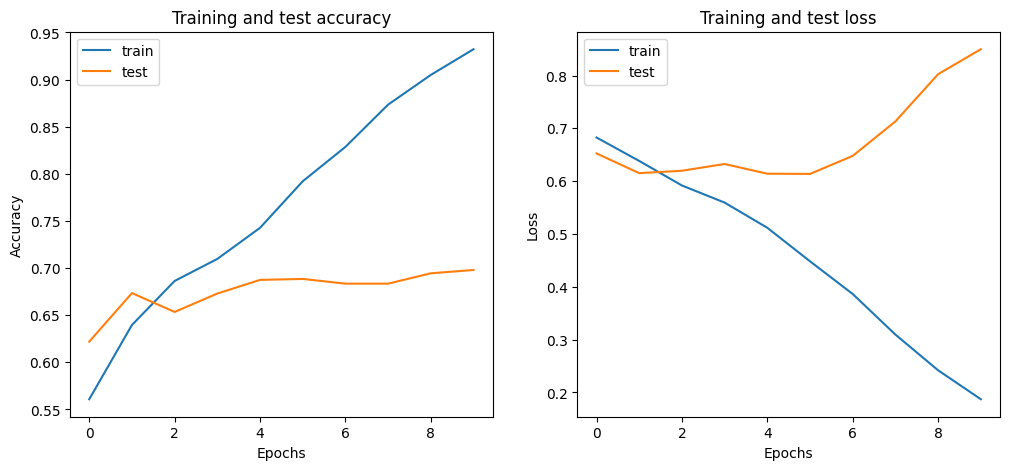

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

epochs = range(len(train_lenet_loss))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# Plot training and test accuracy per epoch
plt.plot(epochs, train_lenet_accuracy,label='train')
plt.plot(epochs, test_lenet_accuracy,label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and test accuracy')
plt.legend()


plt.subplot(1,2,2)
# Plot training and test loss per epoch
plt.plot(epochs, train_lenet_loss,label='train')
plt.plot(epochs, test_lenet_loss,label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and test loss')
plt.legend()

## 2. AlexNet

AlexNet is the name of a convolutional neural network (CNN) architecture, designed by Alex Krizhevsky in collaboration with Ilya Sutskever and Geoffrey Hinton, who was Krizhevsky's Ph.D. advisor

AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012.The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. The original paper's primary result was that the depth of the model was essential for its high performance, which was computationally expensive, but made feasible due to the utilization of graphics processing units (GPUs) during training.
(from https://en.wikipedia.org/wiki/AlexNet)


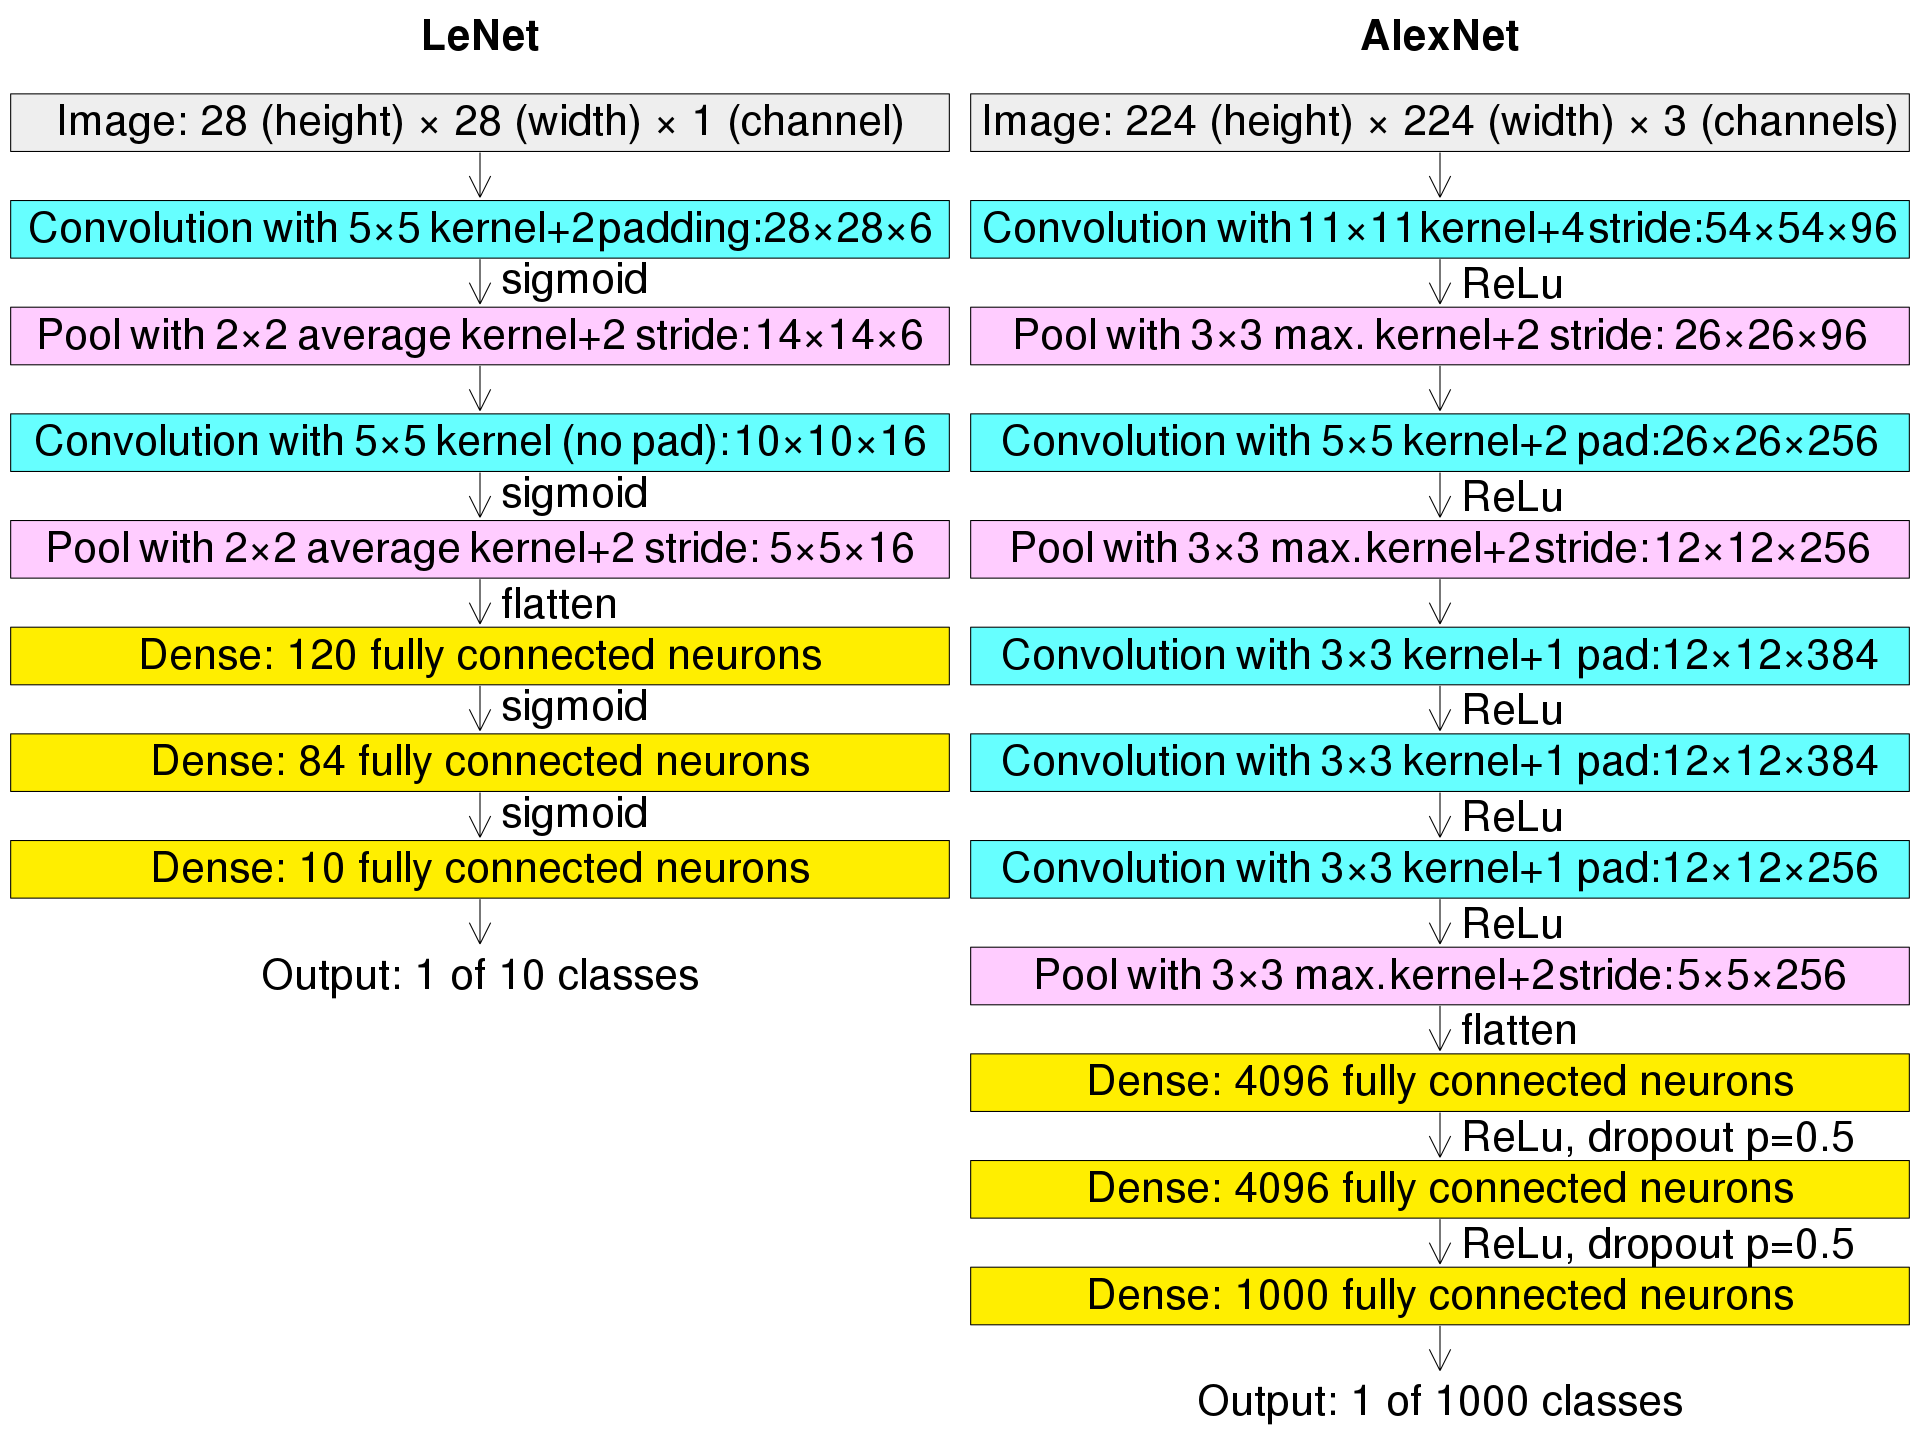

*A model with batch normalization added for stable training.*

In [ ]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # 1st convolutional layer with 11x11 kernel, stride of 4, and padding of 2
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=3, stride=2),  # Max pooling layer with 3x3 kernel and stride of 2
            nn.BatchNorm2d(64),  # Batch normalization

            ####### YOUR CODE HERE #######
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 2nd convolutional layer with 5x5 kernel and padding of 2
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.MaxPool2d(kernel_size=3, stride=2),  # Max pooling layer with 3x3 kernel and stride of 2
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 3rd convolutional layer with 3x3 kernel and padding of 1
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 4th convolutional layer with 3x3 kernel and padding of 1
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 5th convolutional layer with 3x3 kernel and padding of 1
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.MaxPool2d(kernel_size=3, stride=2),  # Max pooling layer with 3x3 kernel and stride of 2
        )

        # Classifier layers
        self.classifier = nn.Sequential(

            ####### YOUR CODE HERE #######
            nn.Dropout(),  # Dropout layer
            nn.Linear(256 * 3 * 3, 4096),  # 1st fully connected layer with 4096 neurons
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.Dropout(),  # Dropout layer
            nn.Linear(4096, 4096),  # 2nd fully connected layer with 4096 neurons
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.Linear(4096, num_classes),  # 3rd fully connected layer with number of classes neurons
            nn.Sigmoid() #binary classification을 사용하기 때문에 추가해줘야한다
        )

    def forward(self, x):
        x = self.features(x)  # Pass input through feature extraction layers
        x = torch.flatten(x, 1)  # Flatten the tensor along the second dimension
        x = self.classifier(x)  # Pass flattened tensor through classifier layers
        return x


# Example usage
net = AlexNet(num_classes=1000)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_

### Check model

In [ ]:
# Create AlexNet model
model_AlexNet = AlexNet().to(device)
optimizer = torch.optim.Adam(model_AlexNet.parameters(), ## Adam optimizer
                            lr=lr,
                            weight_decay = 1e-3)
summary(model_AlexNet, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 36, 36]          23,296
              ReLU-2           [-1, 64, 36, 36]               0
         MaxPool2d-3           [-1, 64, 17, 17]               0
       BatchNorm2d-4           [-1, 64, 17, 17]             128
            Conv2d-5          [-1, 192, 17, 17]         307,392
              ReLU-6          [-1, 192, 17, 17]               0
         MaxPool2d-7            [-1, 192, 8, 8]               0
            Conv2d-8            [-1, 384, 8, 8]         663,936
              ReLU-9            [-1, 384, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         884,992
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
             ReLU-13            [-1, 256, 8, 8]               0
        MaxPool2d-14            [-1, 25

### Train AlexNet

In [ ]:
train_alexnet_loss, train_alexnet_accuracy = [], []
test_alexnet_loss, test_alexnet_accuracy = [], []

## AlexNet training
for i in range(epoch):
  ## train
  avg_train_loss, avg_train_accuracy = train(model_AlexNet, optimizer, train_loader, i)
  train_alexnet_loss.append(avg_train_loss)
  train_alexnet_accuracy.append(avg_train_accuracy)

  ## test
  avg_test_loss, avg_test_accuracy = test(model_AlexNet, optimizer, test_loader, i)
  test_alexnet_loss.append(avg_test_loss)
  test_alexnet_accuracy.append(avg_test_accuracy)

  ## print
  print(f'epoch {i}) train loss : {avg_train_loss:.4f} / train_accuracy : {avg_train_accuracy:.4f} \
  / test loss : {avg_test_loss:.4f} / test_accuracy : {avg_test_accuracy:.4f}')

epoch 0) train loss : 0.6987 / train_accuracy : 0.5041   / test loss : 0.6931 / test_accuracy : 0.5000
epoch 1) train loss : 0.6932 / train_accuracy : 0.5002   / test loss : 0.6932 / test_accuracy : 0.5000
epoch 2) train loss : 0.6932 / train_accuracy : 0.4914   / test loss : 0.6932 / test_accuracy : 0.5000
epoch 3) train loss : 0.6932 / train_accuracy : 0.4967   / test loss : 0.6931 / test_accuracy : 0.5000
epoch 4) train loss : 0.6932 / train_accuracy : 0.4986   / test loss : 0.6931 / test_accuracy : 0.5000
epoch 5) train loss : 0.6931 / train_accuracy : 0.5090   / test loss : 0.6934 / test_accuracy : 0.5000
epoch 6) train loss : 0.6933 / train_accuracy : 0.5058   / test loss : 0.6932 / test_accuracy : 0.5000
epoch 7) train loss : 0.6933 / train_accuracy : 0.4966   / test loss : 0.6932 / test_accuracy : 0.5000
epoch 8) train loss : 0.6933 / train_accuracy : 0.5030   / test loss : 0.6933 / test_accuracy : 0.5000
epoch 9) train loss : 0.6937 / train_accuracy : 0.5014   / test loss : 0.

### LeNet vs AlexNet

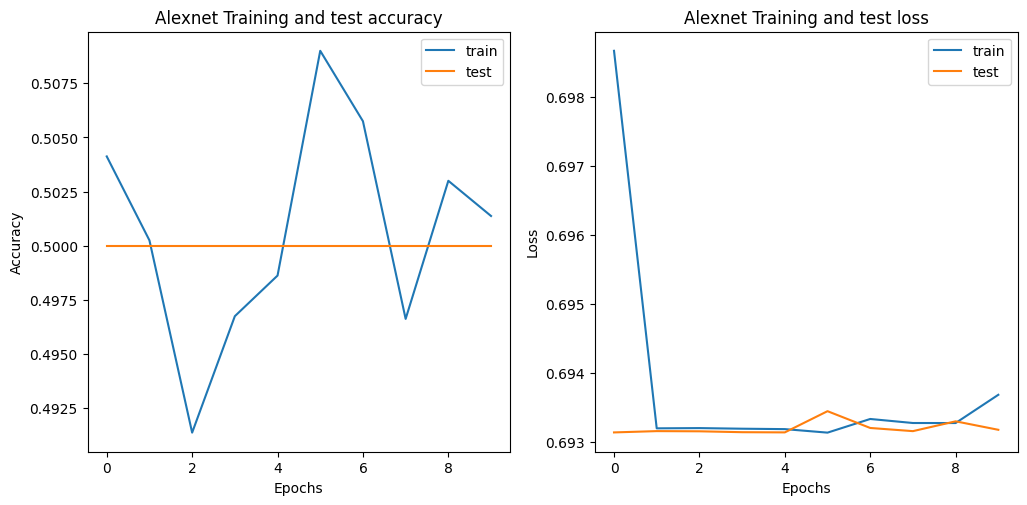

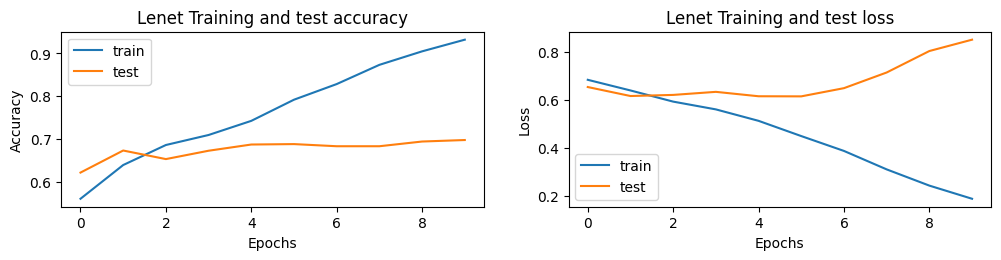

In [ ]:
## LeNet vs AlexNet
%matplotlib inline

import matplotlib.pyplot as plt

epochs = range(len(train_alexnet_loss))
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
# Plot training and test accuracy per epoch
plt.plot(epochs, train_alexnet_accuracy,label='train')
plt.plot(epochs, test_alexnet_accuracy,label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Alexnet Training and test accuracy')
plt.legend()


plt.subplot(2,2,2)
# Plot training and test loss per epoch
plt.plot(epochs, train_alexnet_loss,label='train')
plt.plot(epochs, test_alexnet_loss,label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Alexnet Training and test loss')
plt.legend()


epochs = range(len(train_lenet_loss))
plt.figure(figsize=(12,5))
plt.subplot(2,2,3)
# Plot training and test accuracy per epoch
plt.plot(epochs, train_lenet_accuracy,label='train')
plt.plot(epochs, test_lenet_accuracy,label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Lenet Training and test accuracy')
plt.legend()


plt.subplot(2,2,4)
# Plot training and test loss per epoch
plt.plot(epochs, train_lenet_loss,label='train')
plt.plot(epochs, test_lenet_loss,label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Lenet Training and test loss')
plt.legend()







## 3. Going Deeper (VGGNet & GoogLeNet)
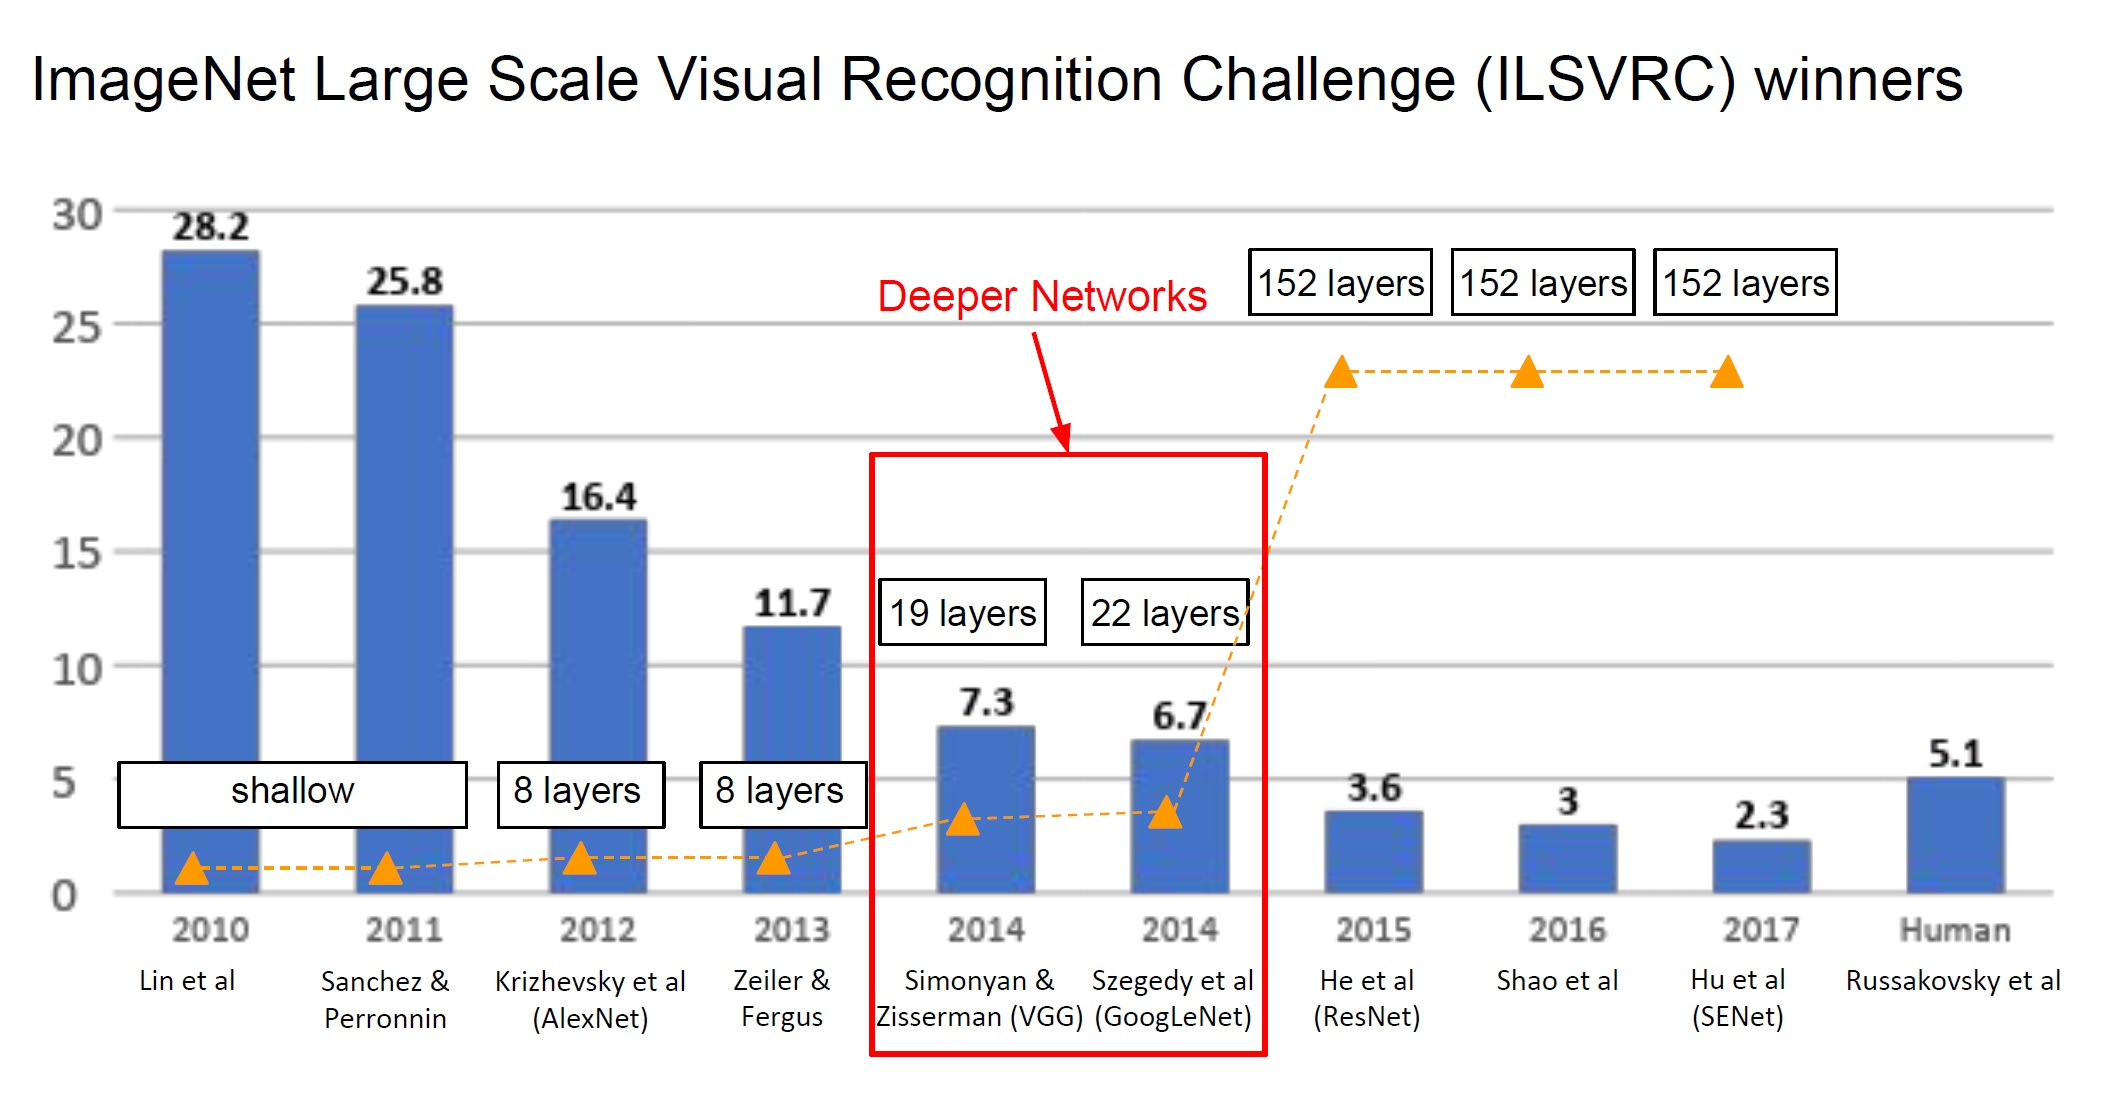

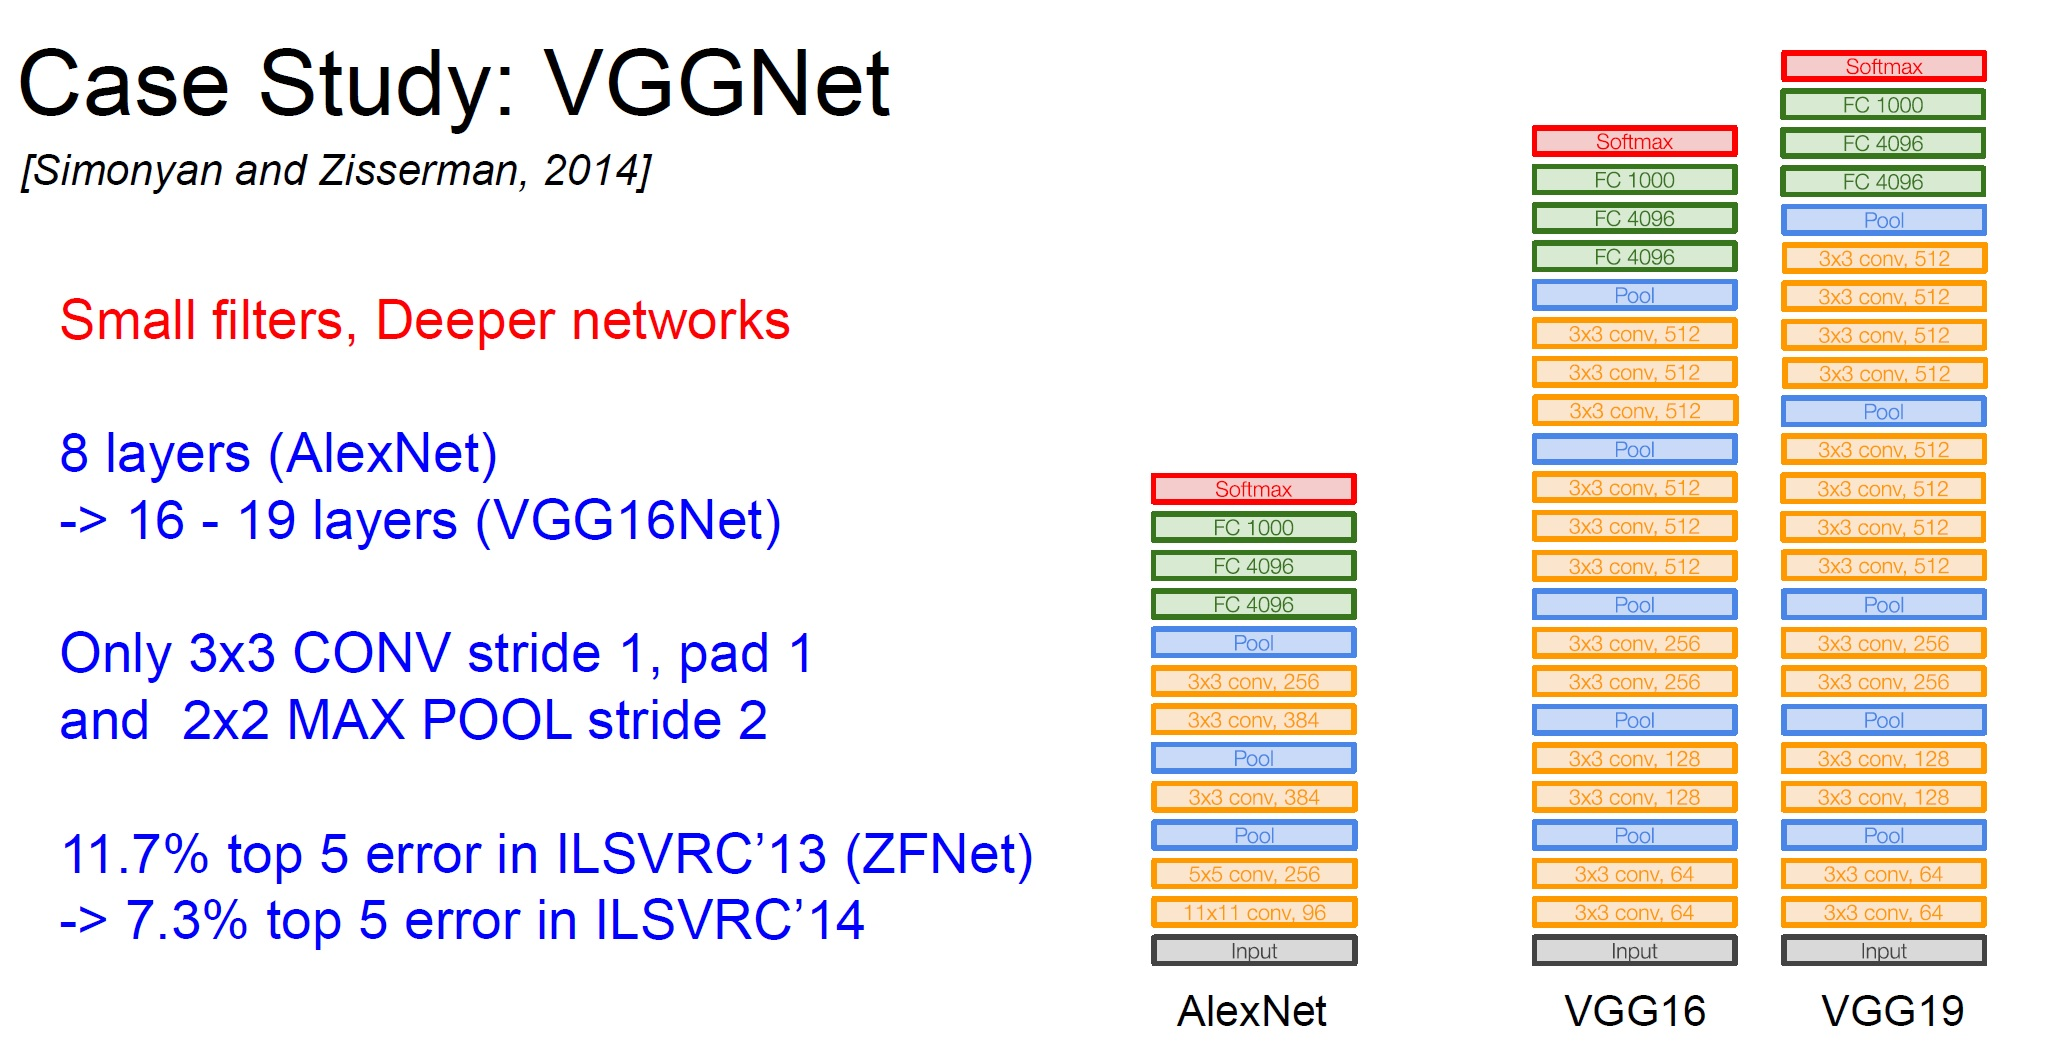

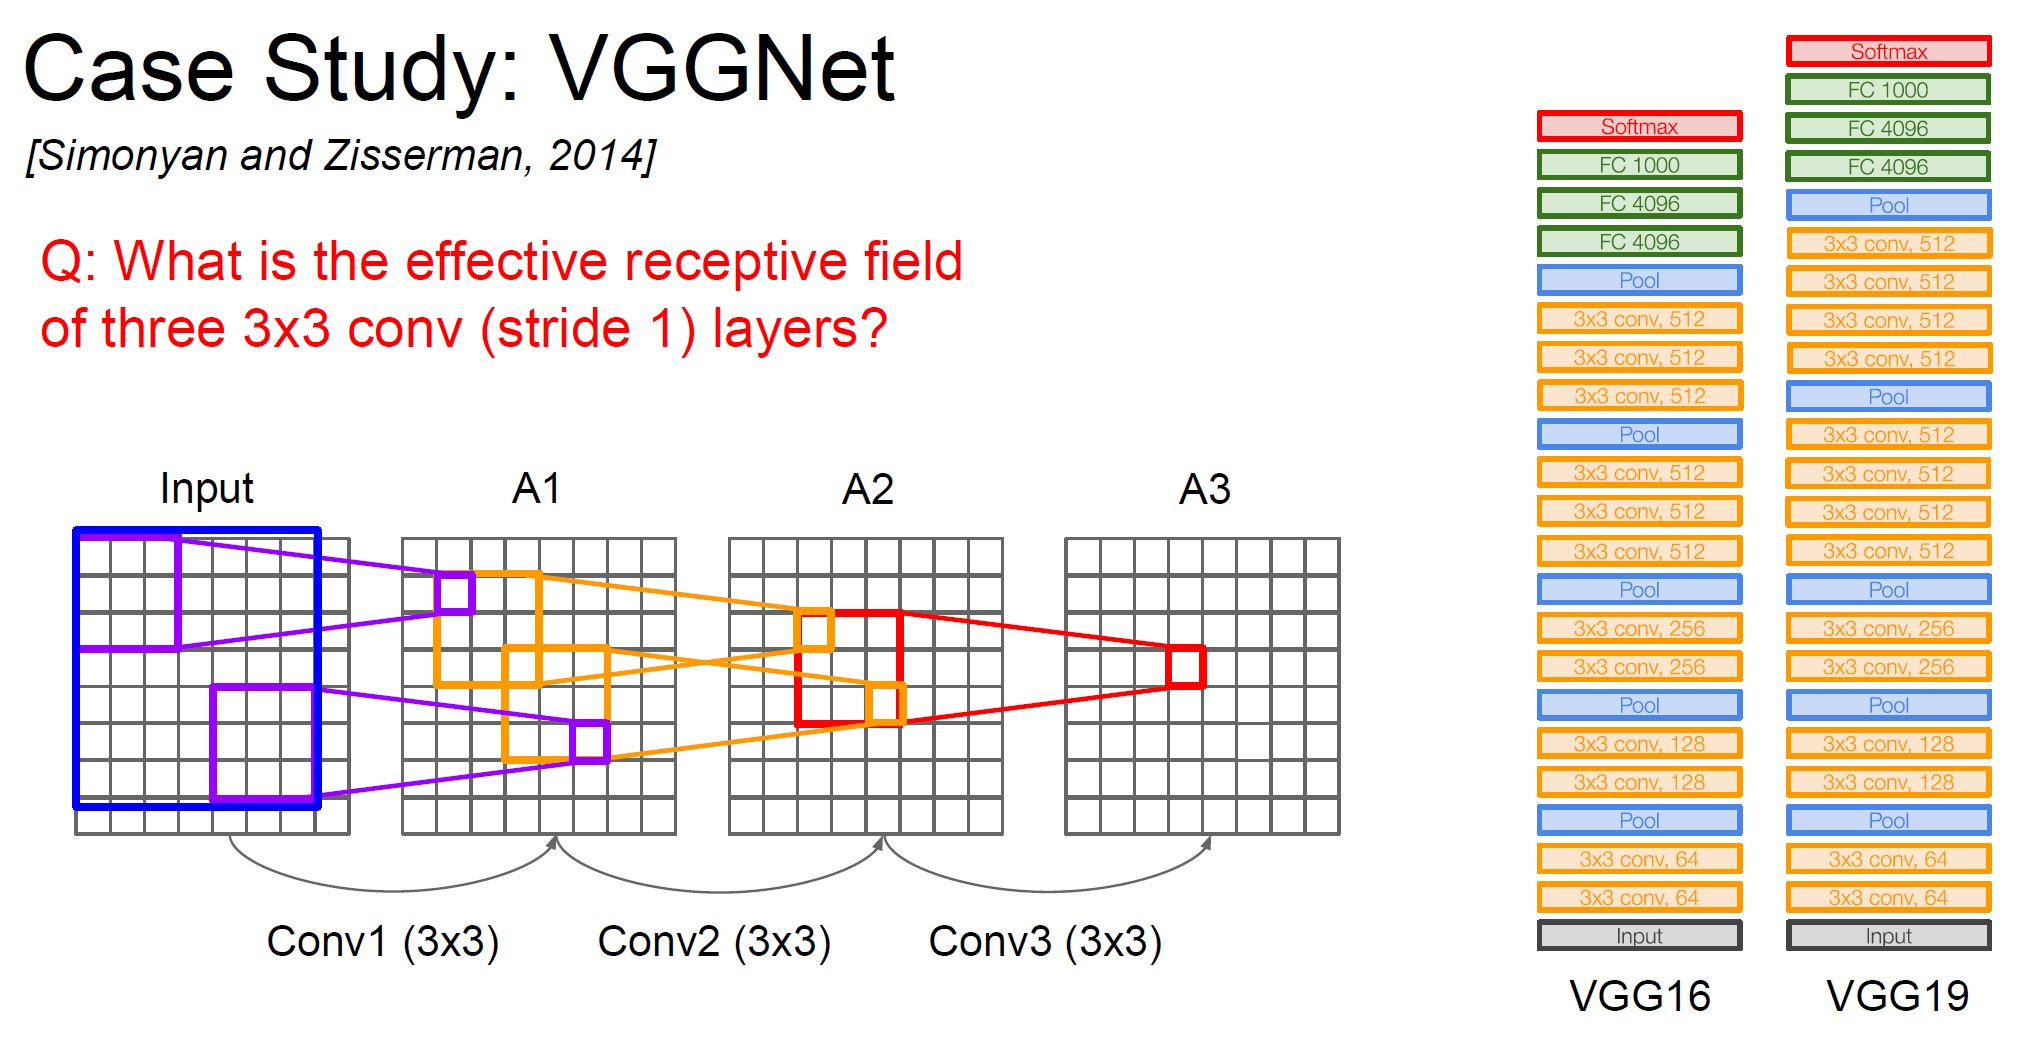

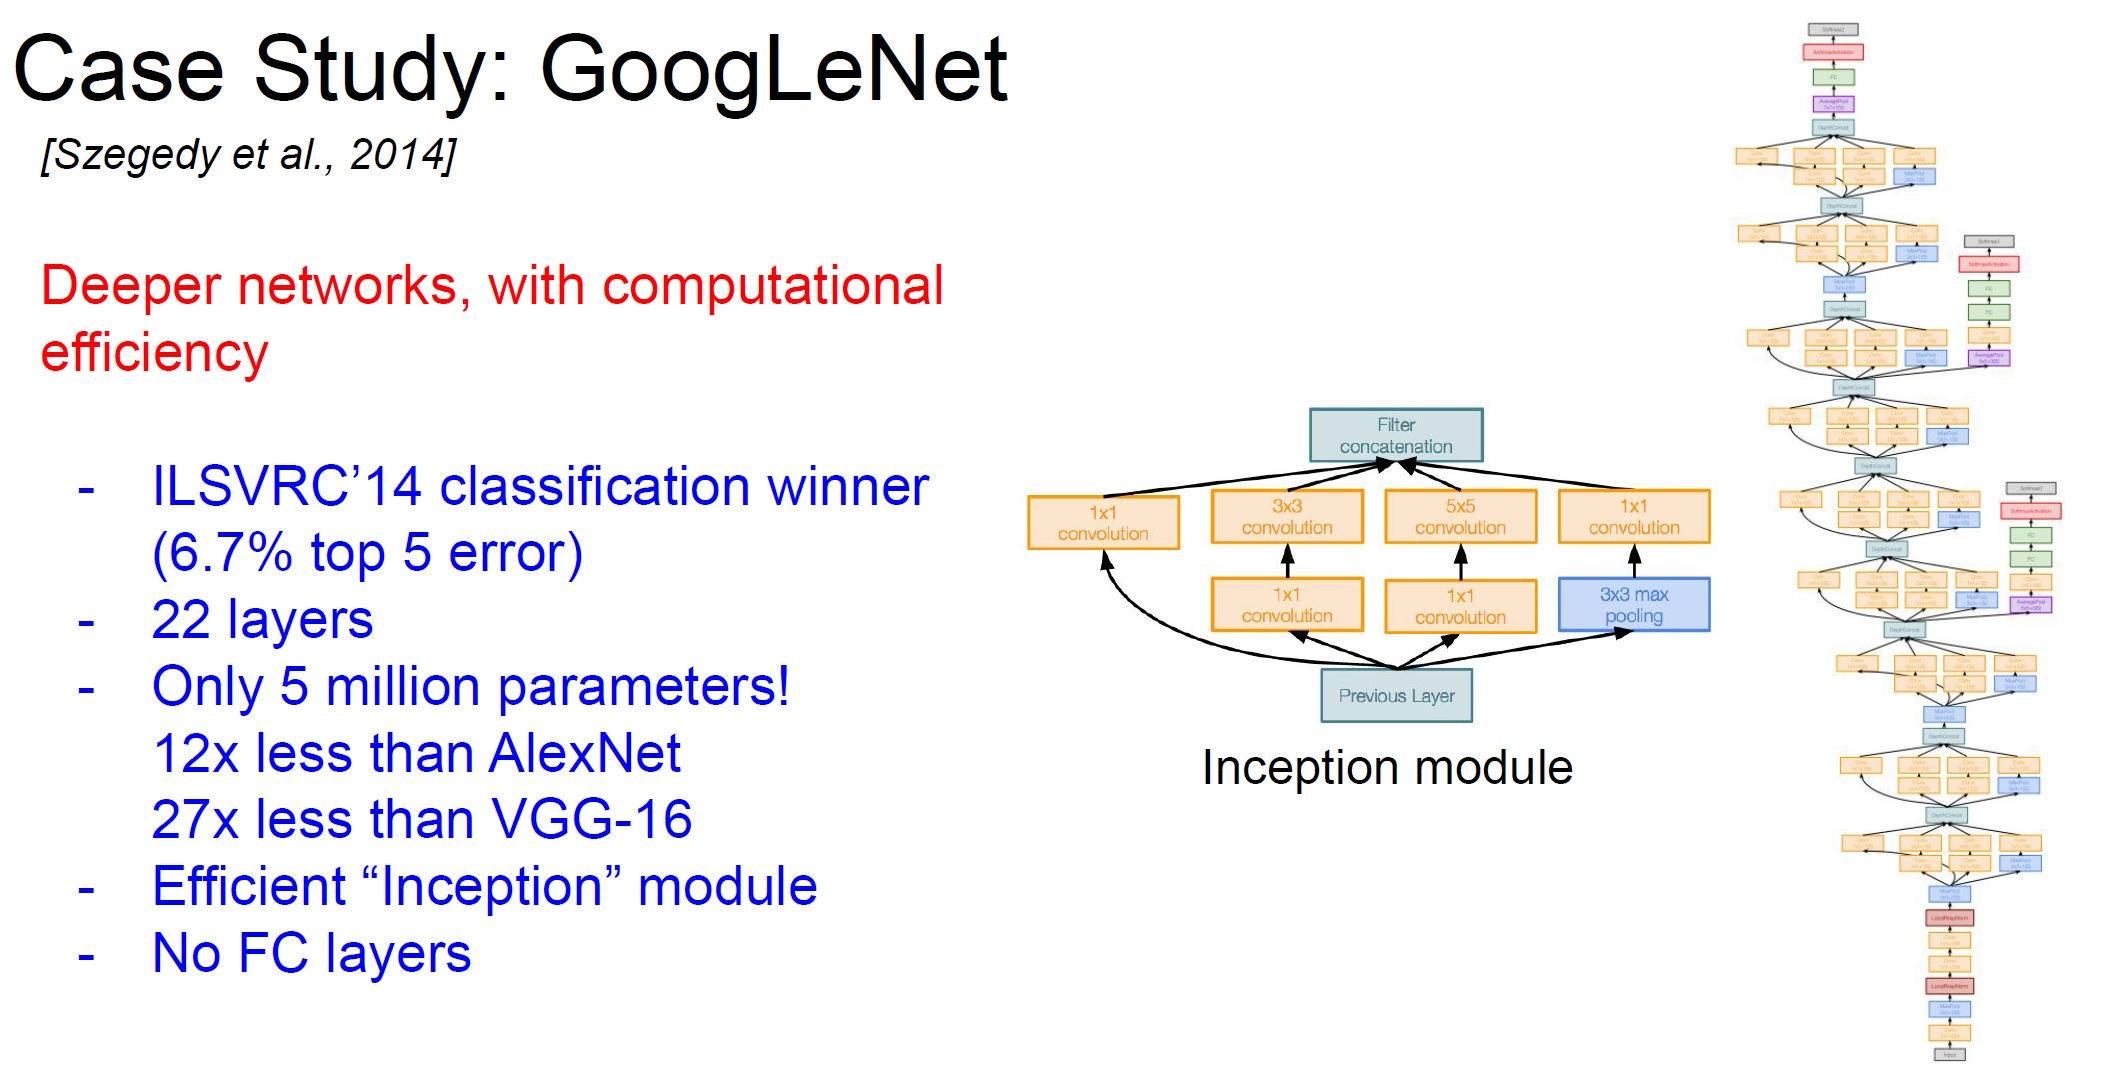

## 4. ResNet

To avoid gradient vanishing or exploding problems!

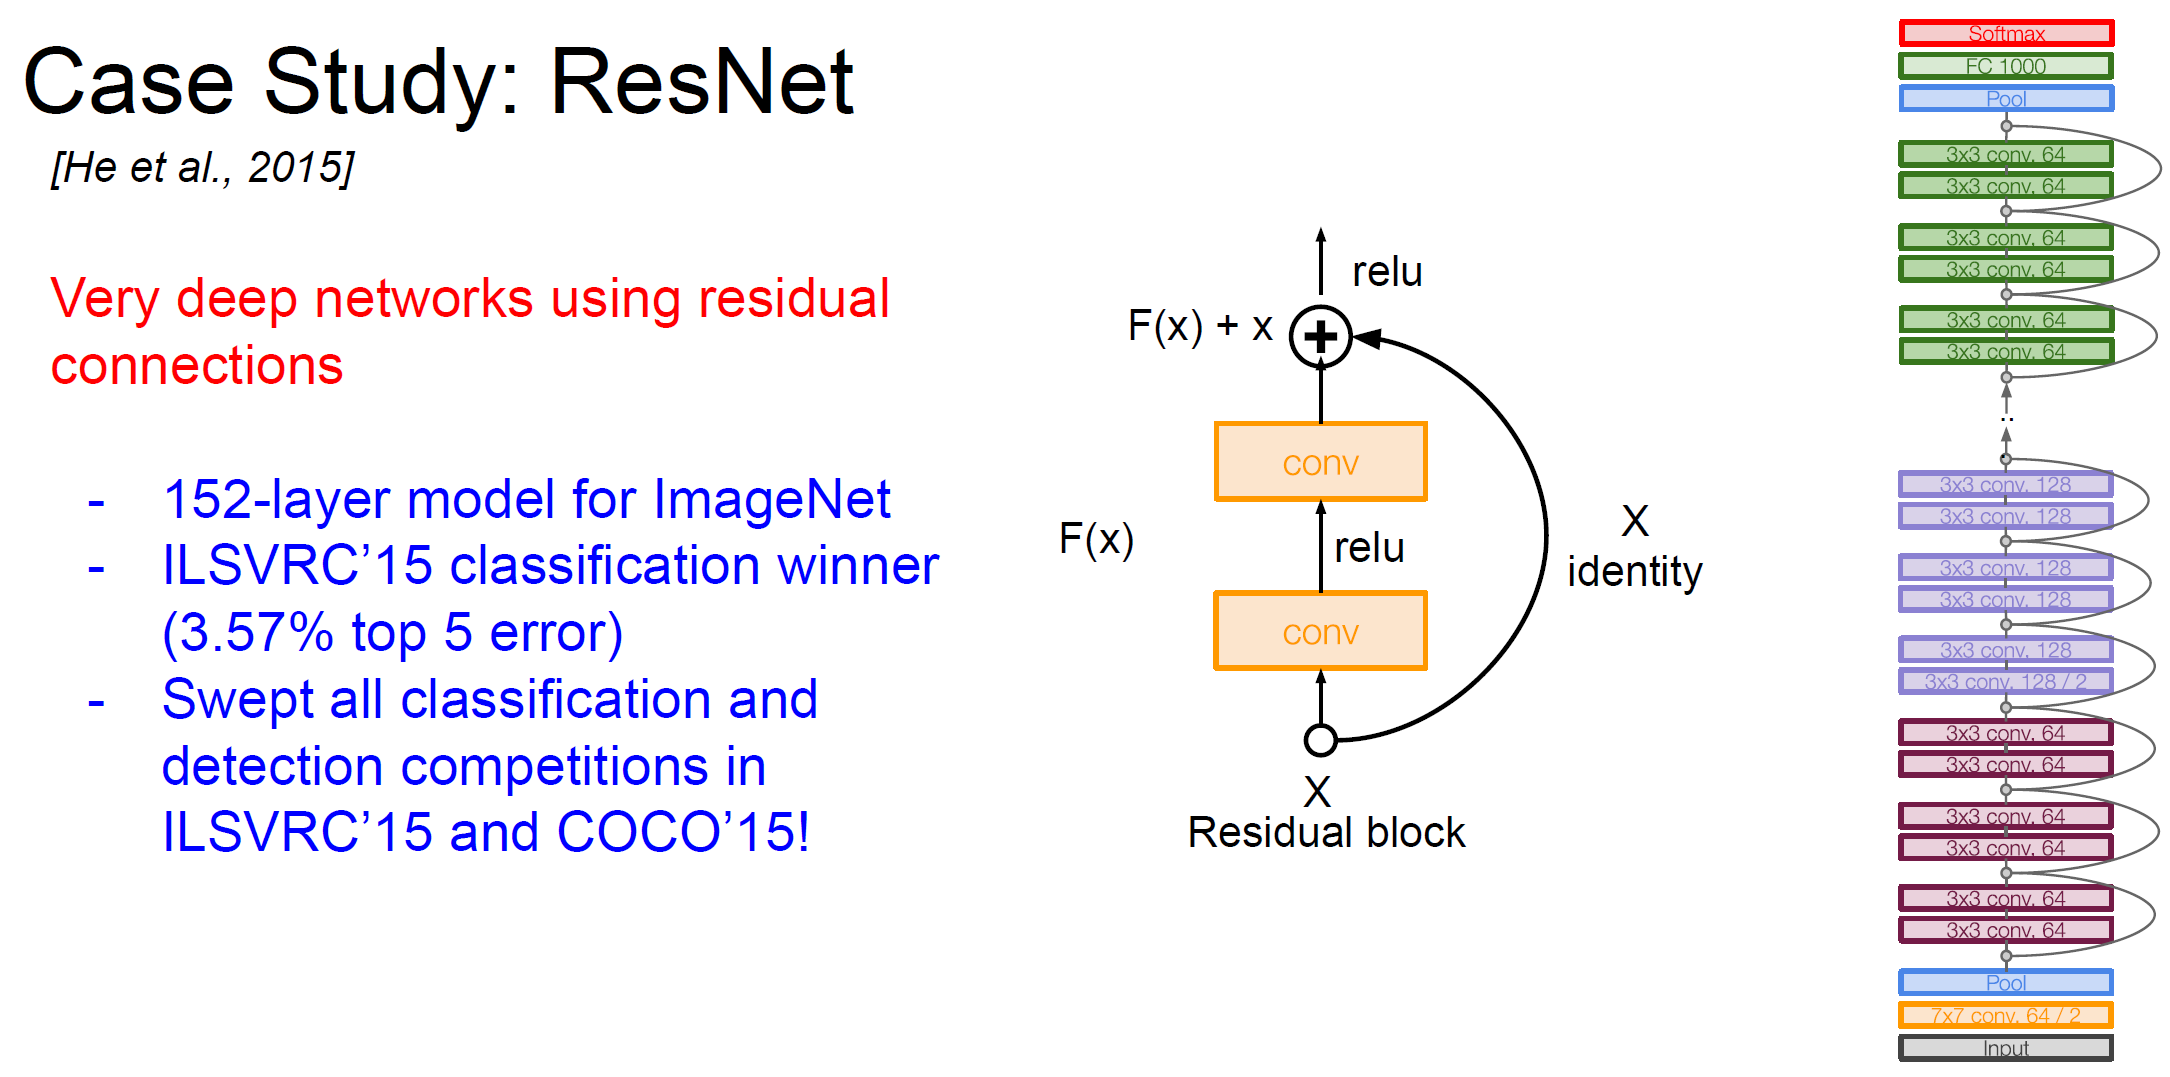

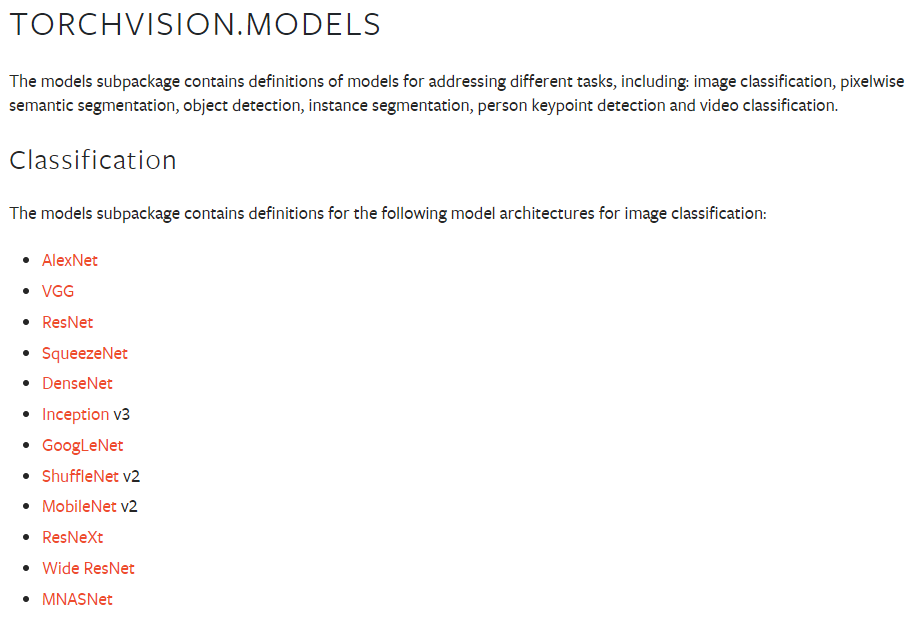

https://pytorch.org/vision/0.8/models.html#classification

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## parameters
epoch = 10
batchsize = 32
lr = 0.001 # learning rate

## loss function
criterion = torch.nn.BCELoss() # Binary Cross Entropy

## dataloader
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batchsize,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)



### Check VGGNet torchvision model

In [ ]:
# Load VGG16 model
model_VGG = models.vgg16()

model_VGG = model_VGG.to(device)
summary(model_VGG, (3, 150, 150))   # summary(your_model, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

### Load ResNet torchvision model

In [ ]:
# Load ResNet50 model
model_ResNet = models.resnet50()

# Modify the first convolutional layer to accept 3x150x150 input
model_ResNet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the classifier for binary classification
model_ResNet.fc = nn.Sequential(
    nn.Linear(2048, 1),
    nn.Sigmoid()
)
# Print the structure of the model for verification
model_ResNet = model_ResNet.to(device)
optimizer = torch.optim.Adam(model_ResNet.parameters(), ## Adam optimizer
                            lr=lr,
                            weight_decay = 1e-6)
summary(model_ResNet, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]           4,096
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
           Conv2d-11          [-1, 256, 38, 38]          16,384
      BatchNorm2d-12          [-1, 256, 38, 38]             512
           Conv2d-13          [-1, 256, 38, 38]          16,384
      BatchNorm2d-14          [-1, 256,

### Train ResNet

In [ ]:
def train(model, optimizer, train_loader, epoch):
  train_loss = []
  train_accuracy = []
  model.train()
  for i, (X,y) in enumerate(train_loader):
      X,y = X.to(device), y.to(device).view(-1,1)
      optimizer.zero_grad()
      predict = model(X)
      loss = criterion(predict, y)
      loss.backward()
      optimizer.step()

      accuracy = torch.count_nonzero((predict>=0.5) == y)/X.shape[0]
      train_accuracy.append(accuracy)
      train_loss.append(loss)
  avg_loss = sum(train_loss) /len(train_loss)
  avg_accuracy = sum(train_accuracy) / len(train_accuracy)

  return avg_loss.cpu().detach(), avg_accuracy.cpu().detach()

def test(model, optimizer, test_loader, epoch):
  test_loss = []
  test_accuracy = []
  model.eval()
  for i, (X,y) in enumerate(test_loader):
      with torch.no_grad(): ## Since backward computation is not necessary during test time, turning off grad reduces memory and computational overhead.
        X,y = X.to(device), y.to(device).view(-1,1)
        predict = model(X)
        loss = criterion(predict, y)
        accuracy = torch.count_nonzero((predict>=0.5) == y)
        test_accuracy.append(accuracy)
        test_loss.append(loss)
  avg_loss = sum(test_loss) /len(test_loss)
  avg_accuracy = sum(test_accuracy) / len(test_accuracy)
  return avg_loss.cpu().detach(), avg_accuracy.cpu().detach()


In [ ]:
train_resnet_loss, train_resnet_accuracy = [], []
test_resnet_loss, test_resnet_accuracy = [], []

## ResNet training
for i in range(epoch):
  ## train
  avg_train_loss, avg_train_accuracy = train(model_ResNet, optimizer, train_loader, i)
  train_resnet_loss.append(avg_train_loss)
  train_resnet_accuracy.append(avg_train_accuracy)

  ## test
  avg_test_loss, avg_test_accuracy = test(model_ResNet, optimizer, test_loader, i)
  test_resnet_loss.append(avg_test_loss)
  test_resnet_accuracy.append(avg_test_accuracy)

  ## print
  print(f'epoch {i}) train loss : {avg_train_loss:.4f} / train_accuracy : {avg_train_accuracy:.4f} \
  / test loss : {avg_test_loss:.4f} / test_accuracy : {avg_test_accuracy:.4f}')

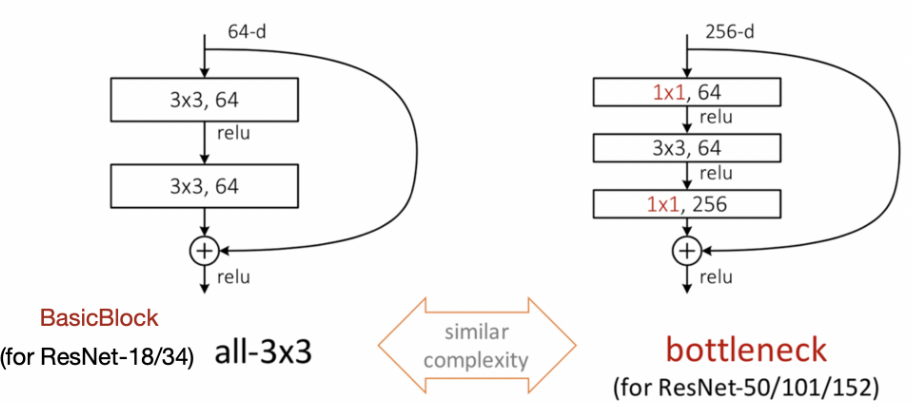

## ResNet18 직접 구현하기!!

In [ ]:
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()  # identity function
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()

        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = nn.Sequential(
            BasicBlock(self.in_planes, 64, stride=1),
            BasicBlock(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128, stride=1)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256, stride=1)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512, stride=1)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = nn.ReLU()(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)

        return x

In [ ]:
#Build your own custom ResNet

import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):



    def forward(self, x):



class ResNetYours(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNetYours, self).__init__()



    def forward(self, x):


        return x

In [ ]:
model_ResNet18 = ResNet18(num_classes=1).to(device)
optimizer = torch.optim.Adam(model_ResNet18.parameters(), ## Adam optimizer
                            lr=lr,
                            weight_decay = 1e-6)
summary(model_ResNet18, (3, 150, 150))

In [ ]:
train_resnet_loss, train_resnet_accuracy = [], []
test_resnet_loss, test_resnet_accuracy = [], []

## ResNet training
for i in range(epoch):
  ## train
  avg_train_loss, avg_train_accuracy = train(model_ResNet18, optimizer, train_loader, i)
  train_resnet_loss.append(avg_train_loss)
  train_resnet_accuracy.append(avg_train_accuracy)

  ## test
  avg_test_loss, avg_test_accuracy = test(model_ResNet18, optimizer, test_loader, i)
  test_resnet_loss.append(avg_test_loss)
  test_resnet_accuracy.append(avg_test_accuracy)

  ## print
  print(f'epoch {i}) train loss : {avg_train_loss:.4f} / train_accuracy : {avg_train_accuracy:.4f} \
  / test loss : {avg_test_loss:.4f} / test_accuracy : {avg_test_accuracy:.4f}')

## ResNet source code

In [ ]:
import torch
import torch.nn as nn


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
  ## ResNet의 본체, basicblock과 bottleneck은 다른 클래스로 정의되어 있습니다.
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        # block : residual block, basicblock or bottleneck(좀더 두꺼운 block)중 무엇을 사용할 지 결정하는 파라미터
        # layers : 총 4개의 레이어중 각 레이어에 몇층의 block을 쌓을 건지 결정하는 파라미터
        # num_classes : 클래스 수
        # zero_init_residual : shortcut layer(1x1)의 가중치를 0으로 초기화 여부
        # groups : grouped convolution에서 몇개의 group으로 나눌지 선택, 클수록 여러 그룹으로 나누기때문에 연산량 감소
        #          basicblock은 groups =1, width_per_group =64만 사용가능
        # width_per_group : 그룹당 채널수
        # replace_stride_width_dilation : feature 크기를 조정할 때 stride 대신 dilation conv 사용
        # norm_layer : 특별히 설정하지 않으면 batchnormalization 사용
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64 ## layer의 입력 채널 수
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        ## self._make_layer를 통해 residual block layer를 만듭니다.
        ## make_layer를 호출 할 때 self.inplanes가 내부에서 변화합니다. (_make_layer 함수 참조)
        ## stride를 따로 설정하지 않으면 해당 레이어의 출력 크기는 입력과 같습니다.
        self.layer1 = self._make_layer(block, 64, layers[0])  # stride = 1 이기 때문에 downsample (x)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # global average pooling
        self.fc = nn.Linear(512 * block.expansion, num_classes) # 최종 출력은 num_classes만큼

        for m in self.modules(): # weight initialization
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

  ## block을 blocks만큼 쌓아서 layer를 만듭니다.
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate: # dilate파라미터가 True이면 stride를 diate convolution으로 대체
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion: # self.inplanes != planes * block.expansion : layer의 출력 채널 수
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        ## 레이어의 첫번째 block은 만약 downsampling을 위한 파라미터를 설정했다면 downsample을 수행합니다.
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # self.inplanes를 출력 채널 만큼 증가시킵니다.(다음 레이어의 입력으로 사용되기 때문)
        # 이후 blocks-1의 수만큼 추가적으로 block을 쌓아줍니다.
        for _ in range(1, blocks): ## block의 수
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x): #forward 함수 -> forward_impl을 호출
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet18(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

def resnet34(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

def resnet50(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

def resnet101(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)

def resnet152(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)

def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)